$\huge{\textbf{MIST Isochrones Only Notebook}
}
$

In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [2]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

import pandas as pd #needed for readmist
def readmist(file):
    with open(file) as f:
        #lines = f.readlines()
        df = pd.read_csv(file,comment='#',names = ['EEP','log10_isochrone_age_yr','initial_mass',\
                                                   'star_mass','log_Teff','log_g','log_L','FeH_init',\
                                                   'FeH','Bessell_U','Bessell_B','Bessell_V','Bessell_R',\
                                                   'Bessell_I','2MASS_J','2MASS_H','2MASS_Ks','Kepler_Kp',\
                                                   'Kepler_D51','Hipparcos_Hp','Tycho_B','Tycho_V',\
                                                   'Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev',\
                                                   'Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW',\
                                                   'TESS','phase'],sep='\s+')
        table_out = Table.from_pandas(df)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
files = glob.glob('/Users/joshpovick/desktop/research/Magellanic_Ages/MIST/*.iso.cmd')

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1]+splt[2])

for j in range(len(files)):
    tab = readmist(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)

In [4]:
#Read in all MIST file
mist = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat')
tmist = Table.from_pandas(mist)
rgb = np.where((tmist['EEP']>=495)&(tmist['EEP']<=605)&(tmist['log_Teff']<=3.75))
trgb = tmist[rgb]

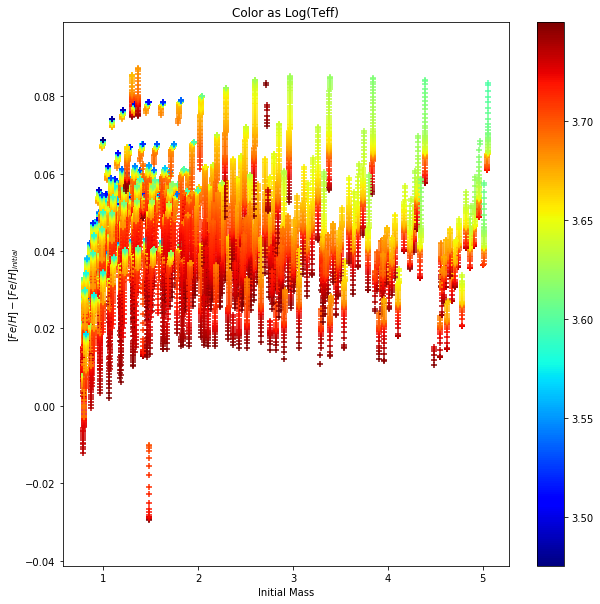

In [5]:
#Mass Metallicity change
plt.figure(figsize=[10,10])
plt.scatter(trgb['initial_mass'],trgb['FeH']-trgb['FeH_init'],marker='+',c=trgb['log_Teff'],cmap='jet')
plt.ylabel(r'$[Fe/H]-[Fe/H]_{initial}$')
plt.xlabel(r'Initial Mass')
plt.colorbar()
plt.title(r'Color as Log(Teff)')
plt.show()

In [6]:
print(max(tmist['FeH_init']))
print(min(tmist['FeH_init']))
print(max(tmist['FeH']))
print(min(tmist['FeH']))
print(tmist['FeH'])

0.1
-2.6
25.626331
-2.878103
        FeH        
-------------------
          -1.361149
          -1.361138
          -1.361148
          -1.361148
          -1.361159
           -1.36117
          -1.361158
-1.3611360000000001
          -1.361158
          -1.361146
                ...
          -0.945468
-0.9454899999999999
          -0.945524
-0.9455629999999999
-0.9455979999999999
-0.9456389999999999
          -0.945684
          -0.945728
          -0.945779
-0.9458559999999999
-0.9459110000000001
Length = 551229 rows


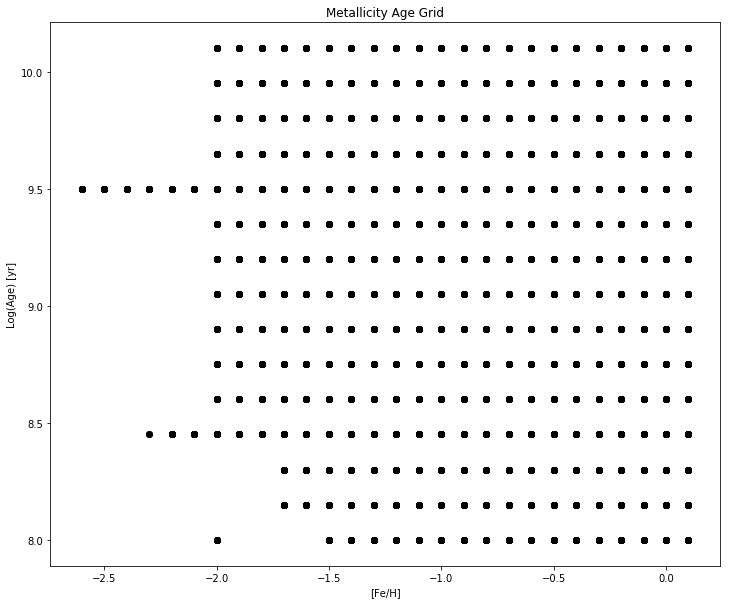

In [7]:
#Metallicity Age
# '''When making rgb cut the grid becomes patchy'''
# plt.figure(figsize=[12,10])
# plt.scatter(tmist['FeH'],tmist['log10_isochrone_age_yr'],c='k')
# plt.ylabel(r'Log(Age) [yr]')
# plt.xlabel(r'[Fe/H]')
# plt.title(r'Metallicity Age Grid')
# plt.savefig('MISTgrid.pdf',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[12,10])
plt.scatter(trgb['FeH_init'],trgb['log10_isochrone_age_yr'],c='k')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('MISTrgbgrid.pdf',bbox_inches='tight')
plt.show()

In [8]:
len(trgb)

26714

In [9]:
#######################################
### Check EEP to find bottom of RGB ###
#######################################

'''Determined that bottom is EEP of 495'''
'''See above picking out RGB when importing data'''

# isotest = np.where((tmist['FeH_init']==-1.0)&(tmist['log10_isochrone_age_yr']==9.35))

# plt.figure(figsize=[10,10])
# plt.scatter(tmist[isotest]['log_Teff'],tmist[isotest]['log_g'],c=tmist[isotest]['FeH_init'],cmap='jet',alpha=0.1)
# plt.scatter(tmist[isotest]['log_Teff'][283],tmist[isotest]['log_g'][283],c='k',marker='+',s=500)
# plt.xlim(3.5,4.0)
# plt.ylim(0,4)
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# # plt.colorbar()
# plt.xlabel(r'Log(T) [K]')
# plt.ylabel(r'Log(g)')
# plt.title(r'Color as [Fe/H]')
# plt.show()

# print(tmist[isotest]['EEP'][283])

'See above picking out RGB when importing data'

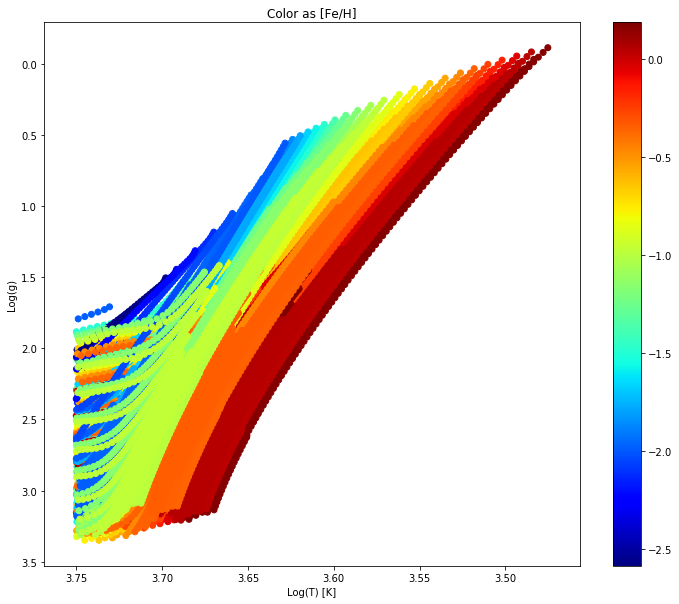

In [10]:
##################
### HR diagram ###
##################

plt.figure(figsize=[12,10])
plt.scatter(trgb['log_Teff'],trgb['log_g'],c=trgb['FeH'],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()
plt.xlabel(r'Log(T) [K]')
plt.ylabel(r'Log(g)')
plt.title(r'Color as [Fe/H]')
plt.show()


In [11]:
##############################
### Import statsmodels.api ###
##############################

import statsmodels.api as sm 

####################
### Prepare Data ###
####################

'''parameters: logTeff, Hmag, [FE/H], logg'''\

logage = np.array(trgb['log10_isochrone_age_yr'].data)

J = np.array(trgb['2MASS_H'].data)
Ks = np.array(trgb['2MASS_Ks'].data)

logteff = np.array(trgb['log_Teff'].data)
H = np.array(trgb['2MASS_H'].data)
feh = np.array(trgb['FeH'])
logg = np.array(trgb['log_g'].data)

In [12]:
# ################################
# ### Fit PARSEC model to MIST ###
# ################################

# print('Using PARSEC Model')

# pmodl = np.array([logteff,Ks,feh,logg,np.multiply(logteff,Ks),np.multiply(logteff,feh),\
#                    np.multiply(logteff,logg),np.multiply(Ks,logg),\
#                    logteff**2,Ks**2,logg**2]).T

# pmodl = sm.add_constant(pmodl)
# model = sm.OLS(logage, pmodl).fit()
# predictions = model.predict(pmodl) 
# residual = predictions - logage
# print_model = model.summary()
# print(print_model)
# print(model.params)

# plt.figure(figsize=[15,10])
# plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
# plt.colorbar(orientation='horizontal')
# plt.gca().invert_xaxis()
# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'Log($T_{eff})$ [K]')
# plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.show()

# print(mad(residual))

# ###############################
# ### Fit BaSTI model to MIST ###
# ###############################

# print(' ')
# print(' ')
# print('Using BaSTI Model')

# pmodl = np.array([logteff,Ks,feh,logg,np.multiply(logteff,Ks),np.multiply(logteff,feh),\
#                   np.multiply(logteff,logg),np.multiply(Ks,logg),np.multiply(logteff**2,feh),\
#                   np.multiply(logteff**2,Ks),logteff**2,Ks**2,logg**2]).T

# pmodl = sm.add_constant(pmodl)
# model = sm.OLS(logage, pmodl).fit()
# predictions = model.predict(pmodl) 
# residual = predictions - logage
# print_model = model.summary()
# print(print_model)
# print(model.params)

# plt.figure(figsize=[15,10])
# plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
# plt.gca().invert_xaxis()
# plt.colorbar(orientation='horizontal')
# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'Log($T_{eff})$ [K]')
# plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.show()

# print(mad(residual))


In [13]:
# ############################
# ### Testing Other Models ###
# ############################

# pmodl = np.array([logteff,Ks,feh,logg,logteff**2,Ks**2,feh**2,logg**2,np.multiply(Ks,logg),\
#                   np.multiply(logteff,Ks)]).T

# pmodl = sm.add_constant(pmodl)
# model = sm.OLS(logage, pmodl).fit()
# predictions = model.predict(pmodl) 
# residual = predictions - logage
# print_model = model.summary()
# print(print_model)
# print(model.params)

# plt.figure(figsize=[15,10])
# plt.scatter(logteff,residual,c=feh,marker='+',s=100,cmap='jet')
# plt.gca().invert_xaxis()
# plt.colorbar(orientation='horizontal')
# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'Log($T_{eff})$ [K]')
# plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.show()

# print(mad(residual))

$\huge{\textbf{Generate and Test All Models}}$

In [14]:
import itertools as it

y1 = logteff
y2 = Ks
y3 = feh
y4 = logg
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

In [15]:
######################
### Fit All Models ###
######################

model_mads = []
model_params = []
model_res = []
#test = models[0:25]
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(logage,pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - logage
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(model.params)

0.006752074821650744
[array(['y1', 'y2', 'y3', 'y4', 'y14', 'y24', 'y2sq', 'y3sq', 'y4sq'],
      dtype='<U4')]


(array([14., 27., 24.,  1.,  1.,  6.,  6.,  1.,  2.,  2.,  2.,  4.,  5.,
         1.,  0.,  2.,  6.,  4.,  4.,  3.,  3.,  1.,  3.,  2.,  2.,  2.,
         3.,  5.,  4.,  4.,  5.,  3.,  1.,  9.,  8.,  2.,  5.,  7.,  8.,
        15.,  5., 10.,  6.,  5., 16., 12., 12.,  8.,  5.,  9.,  4., 10.,
        12.,  8., 14., 20., 16., 34., 20.,  9., 11., 35., 23., 28., 39.,
        38., 32., 50., 32., 34.,  5.,  8., 15., 14., 13., 18., 15., 14.,
        11.,  7.,  5.,  6.,  5.,  9., 17., 10.,  6.,  6.,  6.,  7.,  3.,
        10.,  9., 11.,  9.,  7.,  3.,  1.,  4.,  6.]),
 array([0.00675207, 0.00708405, 0.00741602, 0.00774799, 0.00807997,
        0.00841194, 0.00874391, 0.00907589, 0.00940786, 0.00973983,
        0.01007181, 0.01040378, 0.01073575, 0.01106773, 0.0113997 ,
        0.01173167, 0.01206365, 0.01239562, 0.01272759, 0.01305957,
        0.01339154, 0.01372351, 0.01405549, 0.01438746, 0.01471943,
        0.01505141, 0.01538338, 0.01571535, 0.01604733, 0.0163793 ,
        0.01671127, 0.0170

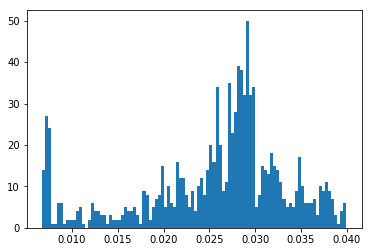

In [16]:
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
np.asarray(model_params)[best]

plt.hist(model_mads,bins=100)
#plt.axvline(min(model_mads),c='k')
#plt.show()

In [17]:
#########################################
### Dataframe With All Possible Terms ### 
#########################################

mod_df = pd.DataFrame()
mod_df['logage'] = logage
mod_df['y1'] = logteff
mod_df['y2'] = Ks
mod_df['y3'] = feh
mod_df['y4'] = logg
mod_df['y12'] = np.multiply(logteff,Ks)
mod_df['y13'] = np.multiply(logteff,feh)
mod_df['y14'] = np.multiply(logteff,logg)
mod_df['y23'] = np.multiply(Ks,feh)
mod_df['y24'] = np.multiply(Ks,logg)
mod_df['y34'] = np.multiply(feh,logg)
mod_df['y1sq'] = logteff**2
mod_df['y2sq'] = Ks**2
mod_df['y3sq'] = feh**2
mod_df['y4sq'] = logg**2
mod_df['y1cu'] = logteff**3
mod_df['y2cu'] = Ks**3
mod_df['y3cu'] = feh**3
mod_df['y4cu'] = logg**3
mod_df.columns

Index(['logage', 'y1', 'y2', 'y3', 'y4', 'y12', 'y13', 'y14', 'y23', 'y24',
       'y34', 'y1sq', 'y2sq', 'y3sq', 'y4sq', 'y1cu', 'y2cu', 'y3cu', 'y4cu'],
      dtype='object')

In [18]:
mod_df[['y1','y2','y3','y4']].cov()

,y1,y2,y3,y4
y1,0.002314,0.058297,-0.013856,0.028774
y2,0.058297,2.635845,-0.089166,1.086933
y3,-0.013856,-0.089166,0.422080,-0.009952
y4,0.028774,1.086933,-0.009952,0.499287


In [19]:
trgb.columns

<TableColumns names=('EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff','log_g','log_L','FeH_init','FeH','Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I','2MASS_J','2MASS_H','2MASS_Ks','Kepler_Kp','Kepler_D51','Hipparcos_Hp','Tycho_B','Tycho_V','Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev','Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW','TESS','phase')>

In [20]:
print(max(trgb['2MASS_H']))
print(min(trgb['2MASS_H']))

0.407194
-6.658025
